## **1. Introduction du projet**

## **Objectif au Projet**

Ce projet vise à concevoir un système de reconnaissance d'images permettant d'identifier avec précision différentes catégories de panneaux de signalisation routière. Il suit une méthodologie en neuf étapes, couvrant l'introduction et l'analyse des données, l'entraînement et l'évaluation du modèle, ainsi que des phases d'amélioration et d'expérimentation, jusqu'à l'interpération des résultats. L'approche repose sur l'apprentissage automatique, en particulier les réseaux de neurones convolutionnels (CNN), et intègre diverses stratégies d'augmentation de données et de régularisation pour optimiser les performances du modèle.


## **Contenu des données**

**Meta : Regroupe les métadonnées associées au jeu de données, incluant des informations sur chaque pictogramme, telles que son emplacement, sa forme, sa couleur et son identifiant unique.**

- Path : chemin d'accès au fichier
- ClassId : identifiant unique du pictogramme parmi les 43 classes existantes
- ShapeId : identifiant de la forme (0-triangle, 1-cercle, 2-losange, 3-hexagone, 4-triangle inversé)
- ColorId : identifiant de la couleur (0-rouge, 1-bleu, 2-jaune, 3-blanc)
- SignId : identifiant du panneau selon le code de la route ukrainien

**Training et test: Contient les images des panneaux de signalisation appartenant aux 43 classes du dataset, avec des versions augmentées pour enrichir l’entraînement et le test du modèle.** 

- Width : largeur de l’image
- Height : hauteur de l’image
- Roi.X1 : coordonnée X du coin supérieur gauche du panneau dans l’image
- Roi.Y1 : coordonnée Y du coin supérieur gauche du panneau dans l’image
- Roi.X2 : coordonnée X du coin inférieur droit du panneau dans l’image
- Roi.Y2 : coordonnée Y du coin inférieur droit du panneau dans l’image
- ClassId : identifiant de la classe correspondant à l’image (43 classes distinctes)
- Path : chemin d’accès à l’image

**La ROI (Region of Interest) est utilisée pour indiquer la zone de l'image qui contient l'objet ou la partie pertinente à analyser.**

**La région d'intérêt (ROI) est un rectangle défini par deux points :**

- Point supérieur gauche : (Roi.X1, Roi.Y1)
- Point inférieur droit : (Roi.X2, Roi.Y2)

Par exemple, pour la première ligne du dataset :
- Roi.X1 = 5, Roi.Y1 = 5 : Coin supérieur gauche de la ROI.
- Roi.X2 = 22, Roi.Y2 = 20 : Coin inférieur droit de la ROI.

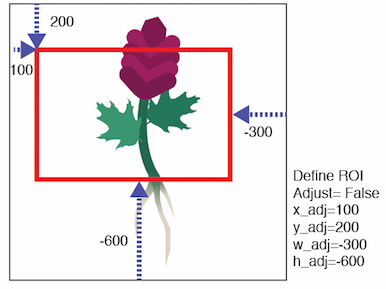

Cela permet de :
- Réduire le bruit : En se concentrant uniquement sur la région pertinente, on évite de traiter des parties inutiles de l'image.
- Améliorer les performances : Les algorithmes peuvent se focaliser sur une zone spécifique, ce qui réduit la complexité et accélère le traitement.
- Annoter les données : La ROI est souvent utilisée pour annoter les objets dans les images, par exemple dans des tâches de détection d'objets ou de classification.

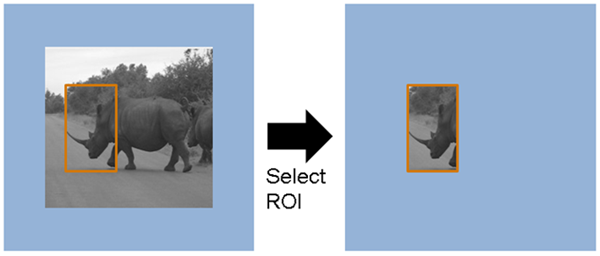
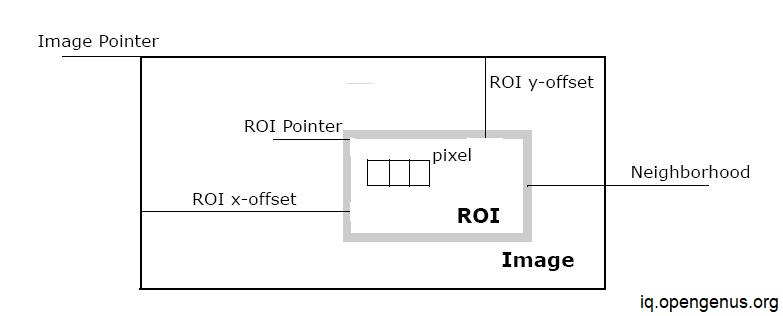
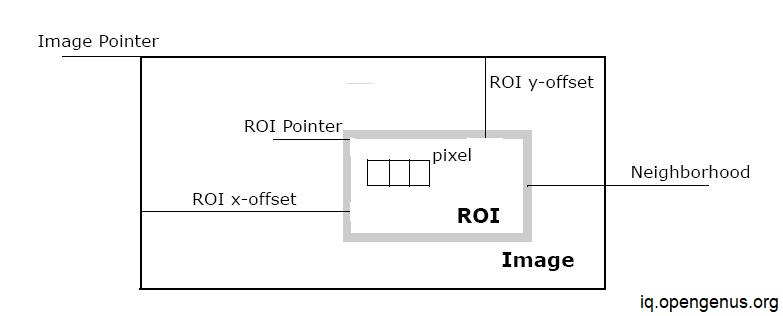
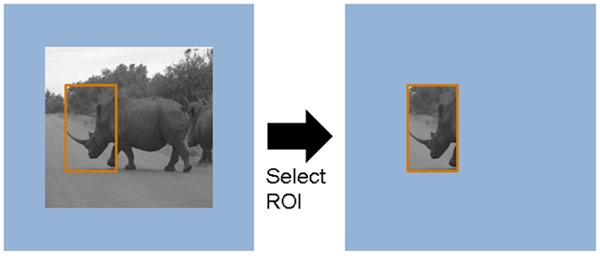
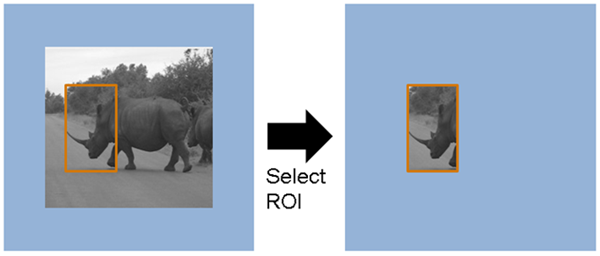

In [1]:
!pip install kagglehub[pandas-datasets]
!pip install openml
!pip install pandas
!pip install numpy
!pip install opencv-python

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.4/160.4 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.1/95.1 kB 7.3 MB/s eta 0:00:00
  Created wheel for liac-arff: filename=liac_arff-2.5.0-py3-none-any.whl size=11716 sha256=10abc9d8163552e0f7bd05d88ea9c58667afaa67c784941467a77fec8a6a4157
  Stored in directory: /root/.cache/pip/wheels/5d/2a/9c/3895d9617f8f49a0883ba686326d598e78a1c2f54fe3cae86d
Successfully built liac-arff


### Loads Librairies

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import os
import kagglehub
from PIL import Image, ImageDraw
from sklearn.model_selection import train_test_split

import tensorflow.keras as keras

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models, callbacks ,layers 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

from IPython.display import clear_output
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.applications import VGG16

In [3]:
# Download latest version
path = kagglehub.dataset_download("meowmeowmeowmeowmeow/gtsrb-german-traffic-sign")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/gtsrb-german-traffic-sign


In [4]:
metabase = pd.read_csv(f"{path}/Meta.csv")
df_train = pd.read_csv(f"{path}/Train.csv")
df_test = pd.read_csv(f"{path}/Test.csv")

In [5]:
metabase.head()

Path  ClassId  ShapeId  ColorId SignId
0  Meta/27.png       27        0        0   1.32
1   Meta/0.png        0        1        0   3.29
2   Meta/1.png        1        1        0   3.29
3  Meta/10.png       10        1        0   3.27
4  Meta/11.png       11        0        0   1.22

In [6]:
df_train.head()

Width  Height  Roi.X1  Roi.Y1  Roi.X2  Roi.Y2  ClassId  \
0     27      26       5       5      22      20       20   
1     28      27       5       6      23      22       20   
2     29      26       6       5      24      21       20   
3     28      27       5       6      23      22       20   
4     28      26       5       5      23      21       20   

                             Path  
0  Train/20/00020_00000_00000.png  
1  Train/20/00020_00000_00001.png  
2  Train/20/00020_00000_00002.png  
3  Train/20/00020_00000_00003.png  
4  Train/20/00020_00000_00004.png

In [7]:
df_test.head()

Width  Height  Roi.X1  Roi.Y1  Roi.X2  Roi.Y2  ClassId            Path
0     53      54       6       5      48      49       16  Test/00000.png
1     42      45       5       5      36      40        1  Test/00001.png
2     48      52       6       6      43      47       38  Test/00002.png
3     27      29       5       5      22      24       33  Test/00003.png
4     60      57       5       5      55      52       11  Test/00004.png

### Exemple d'une image en testant la région d'intérêt 

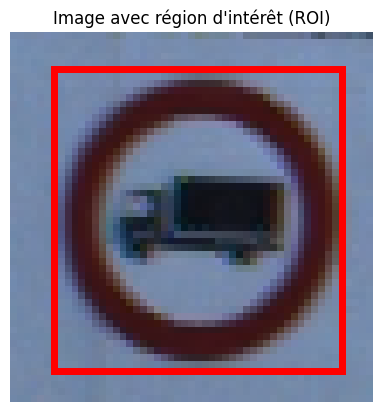

In [8]:
# Charger l'image avec Pillow sur le fichier test
image_path = f"{path}/Test/00000.png"
image = Image.open(image_path)

# Dessiner un rectangle autour de la ROI
Roi_X1, Roi_Y1, Roi_X2, Roi_Y2 = 6,5,48,49
draw = ImageDraw.Draw(image)
draw.rectangle([Roi_X1, Roi_Y1, Roi_X2, Roi_Y2], outline="red")

# Afficher l'image
plt.imshow(image)
plt.title("Image avec région d'intérêt (ROI)")
plt.axis("off")
plt.show()

In [9]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39209 entries, 0 to 39208
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Width    39209 non-null  int64 
 1   Height   39209 non-null  int64 
 2   Roi.X1   39209 non-null  int64 
 3   Roi.Y1   39209 non-null  int64 
 4   Roi.X2   39209 non-null  int64 
 5   Roi.Y2   39209 non-null  int64 
 6   ClassId  39209 non-null  int64 
 7   Path     39209 non-null  object
dtypes: int64(7), object(1)
memory usage: 2.4+ MB


In [10]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12630 entries, 0 to 12629
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Width    12630 non-null  int64 
 1   Height   12630 non-null  int64 
 2   Roi.X1   12630 non-null  int64 
 3   Roi.Y1   12630 non-null  int64 
 4   Roi.X2   12630 non-null  int64 
 5   Roi.Y2   12630 non-null  int64 
 6   ClassId  12630 non-null  int64 
 7   Path     12630 non-null  object
dtypes: int64(7), object(1)
memory usage: 789.5+ KB


In [11]:
nb_class_unique = metabase["ClassId"].unique()
print(nb_class_unique)

[27  0  1 10 11 12 13 14 15 16 17 18 19  2 20 21 22 23 24 25 26 28 29  3
 30 31 32 33 34 35 36 37 38 39  4 40 41 42  5  6  7  8  9]


In [12]:
print(len(nb_class_unique))

43


In [13]:
nb_shape_id = metabase["ShapeId"].unique()
print(nb_shape_id)

[0 1 2 4 3]


In [14]:
nb_color_id = metabase["ColorId"].unique()
print(nb_color_id)

[0 2 3 1]


In [15]:
#Liste des chemins parcours pour l'ensemble des jeu de données 
meta_path = f"{path}/Meta.csv"  
train_path = f"{path}Train.csv"  
test_path = f"{path}Test.csv" 

## Exploration des images pour le fichier Metadonnées

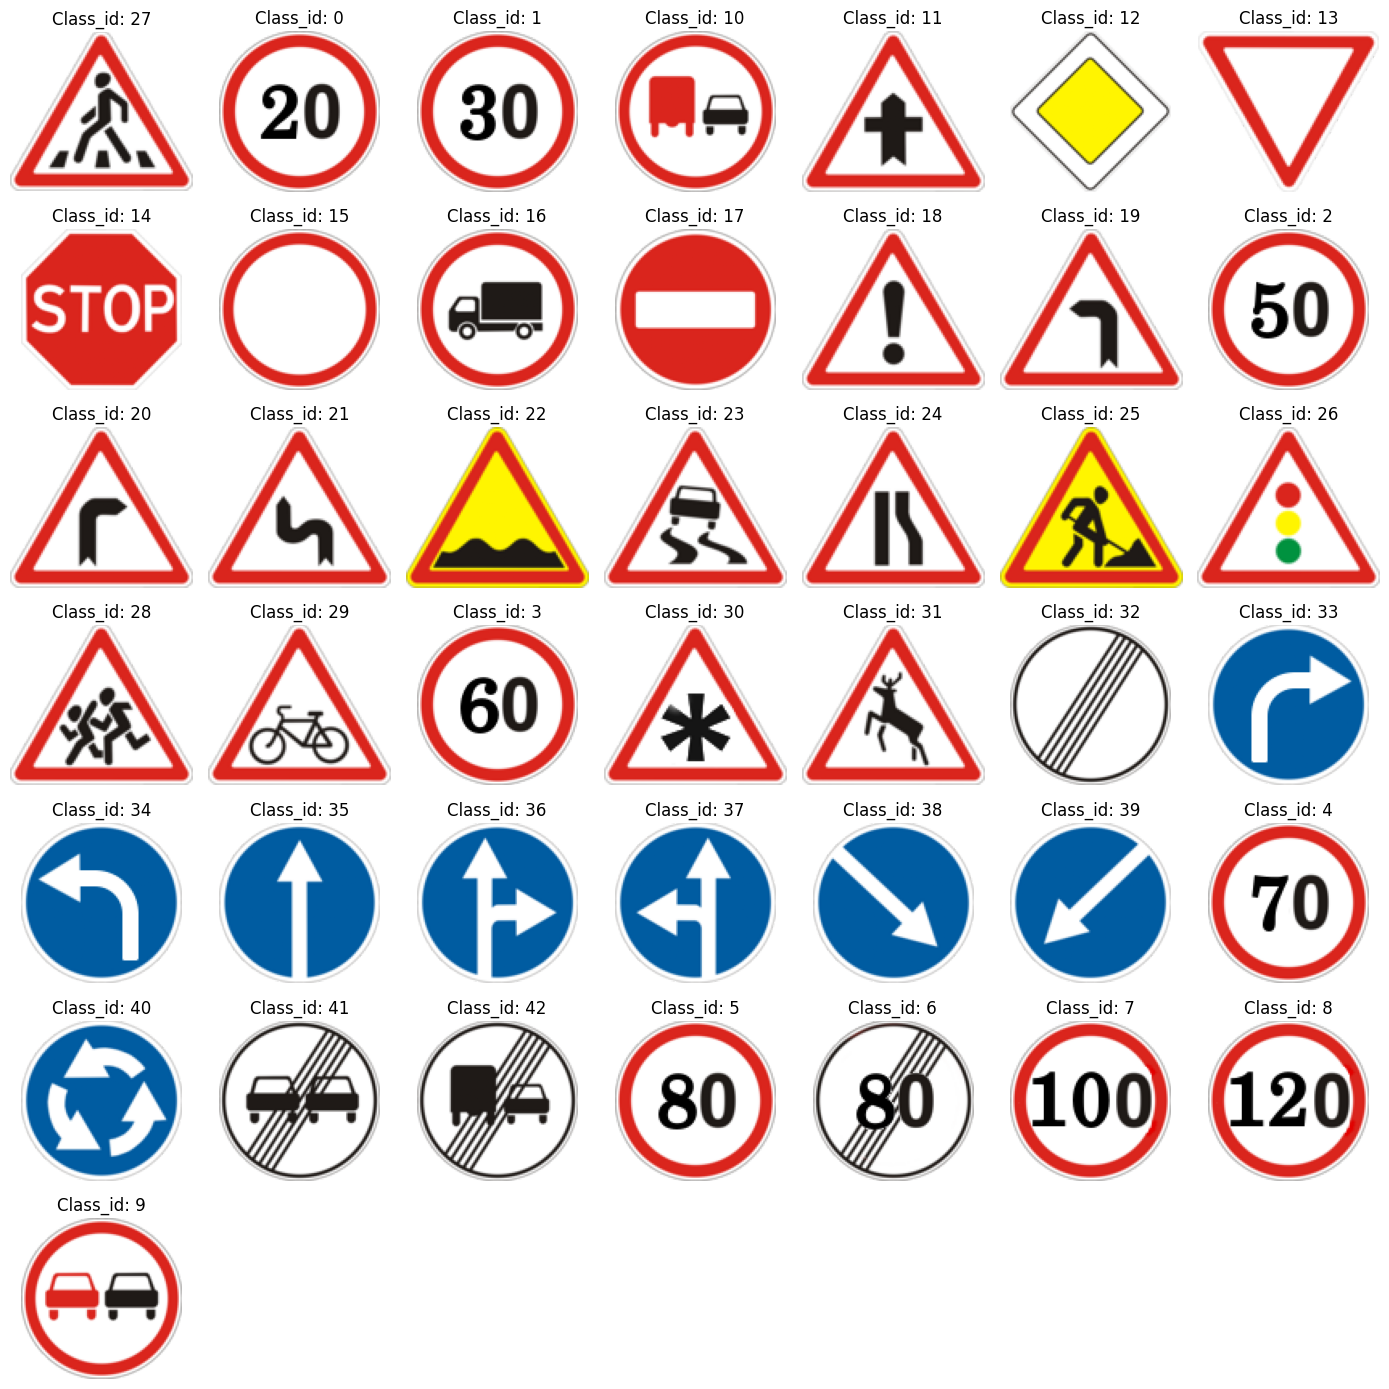

In [16]:
def afficher_images_par_classe(csv_path, path,num_classes=len(nb_class_unique)):
    # Charger le dataset
    df = pd.read_csv(csv_path)  
    
    classes_uniques = df['ClassId'].unique()
    num_cols = 7
    num_rows = -(-num_classes // num_cols)  
    
    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(num_cols * 2, num_rows * 2))
    axes = axes.flatten()
    
    for i, class_id in enumerate(classes_uniques):
        sample = df[df['ClassId'] == class_id].iloc[0]  
        img_path = os.path.join(path, sample['Path'])
        img = mpimg.imread(img_path)
        
        axes[i].imshow(img)
        axes[i].set_title(f'Class_id: {class_id}')
        axes[i].axis('off')
    
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.show()

afficher_images_par_classe(meta_path, path)

## Relevés sur les ID check

- ShapeId : 0: triangle, 1: cercle, 2: losange, 3: Hexagone, 4: Inverse triangle   
- ColorId : 0: rouge, 1: bleu, 2: jaune, 3: blanc

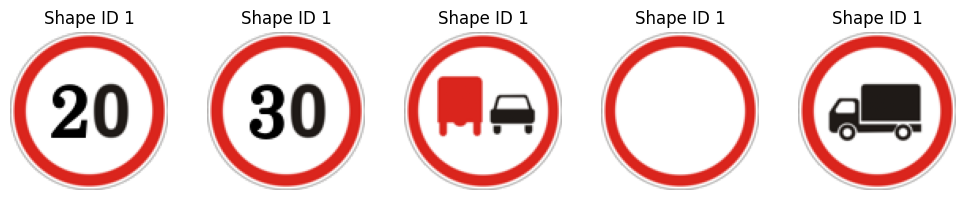

In [17]:
def afficher_images_par_shape(df, path,shape_id=0, num_images=5):
    filtered_df = df[df['ShapeId'] == shape_id].head(num_images)  # Filtrer et limiter le nombre d'images

    num_cols = min(num_images, 5)  # Nombre de colonnes (max 5)
    num_rows = -(-len(filtered_df) // num_cols)  # Arrondi vers le haut
    
    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(num_cols * 2, num_rows * 2))
    axes = axes.flatten()
    
    for i, (_, row) in enumerate(filtered_df.iterrows()):
        img_path = os.path.join(path, row['Path'])
        img = mpimg.imread(img_path)
        axes[i].imshow(img)
        axes[i].set_title(f"Shape ID {shape_id}")
        axes[i].axis("off")
    
    # Désactiver les axes inutilisés
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()

afficher_images_par_shape(metabase,path, shape_id=1, num_images=5)

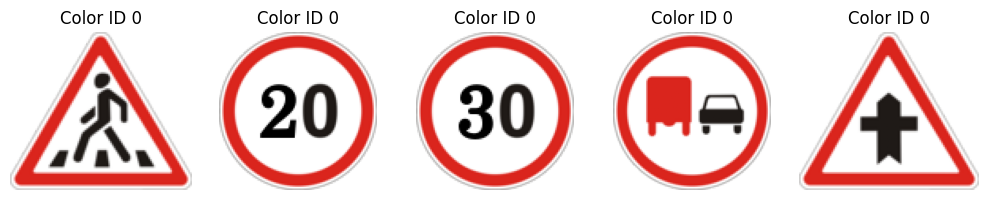

In [18]:
def afficher_images_par_color(df,path,color_id=0, num_images=5):
    filtered_df = df[df['ColorId'] == color_id].head(num_images)  # Filtrer et limiter le nombre d'images

    num_cols = min(num_images, 5)  # Nombre de colonnes (max 5)
    num_rows = -(-len(filtered_df) // num_cols)  # Arrondi vers le haut
    
    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(num_cols * 2, num_rows * 2))
    axes = axes.flatten()
    
    for i, (_, row) in enumerate(filtered_df.iterrows()):
        img_path = os.path.join(path, row['Path'])
        img = mpimg.imread(img_path)
        axes[i].imshow(img)
        axes[i].set_title(f"Color ID {color_id}")
        axes[i].axis("off")
    
    # Désactiver les axes inutilisés
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()

afficher_images_par_color(metabase, path, color_id=0, num_images=5)

## **2. Préparation des données**

### Preprocessing: Redimensionnement et Normalisation 

On couvre 64x64 pixels couvre la majorité des images (au moins 80 % des données).

In [19]:
#Insertion des données ClassID,ShapeID et ColorID sur le jeu de training
merged_data = df_train.merge(metabase[['ClassId', 'ShapeId', 'ColorId']], on='ClassId', how='left')
merged_data['Target'] = merged_data['ClassId'].astype(str) + '_' + merged_data['ShapeId'].astype(str) + '_' + merged_data['ColorId'].astype(str)

In [20]:
merged_data.head()

Width  Height  Roi.X1  Roi.Y1  Roi.X2  Roi.Y2  ClassId  \
0     27      26       5       5      22      20       20   
1     28      27       5       6      23      22       20   
2     29      26       6       5      24      21       20   
3     28      27       5       6      23      22       20   
4     28      26       5       5      23      21       20   

                             Path  ShapeId  ColorId  Target  
0  Train/20/00020_00000_00000.png        0        0  20_0_0  
1  Train/20/00020_00000_00001.png        0        0  20_0_0  
2  Train/20/00020_00000_00002.png        0        0  20_0_0  
3  Train/20/00020_00000_00003.png        0        0  20_0_0  
4  Train/20/00020_00000_00004.png        0        0  20_0_0

In [21]:
def redimensionner_normaliser(img_path, target_size=(64, 64)):
    # Charger l'image à partir du chemin donné
    img = Image.open(img_path)
    img = img.resize(target_size)
    img_array = np.array(img)
    
    img_array = img_array / 255.0  # Normalisation des pixels [Intervalle entre 0 à 1]
    
    return img_array

def charger_donnees(df, path, target_size=(64, 64)):    
    # Initialisation des listes pour X (images) et y (labels)
    X = []
    y = []
    
    # Parcours de toutes les lignes du dataframe
    for _, row in df.iterrows():
        target = row['ClassId']
        img_path = os.path.join(path, row['Path'])
        
        # Appliquer le redimensionnement et la normalisation dans une seule fonction
        img_array = redimensionner_normaliser(img_path, target_size)
        
        X.append(img_array)
        y.append(target)
    
    X = np.array(X)
    y = np.array(y)
    
    return X, y


X, y = charger_donnees(merged_data, path)

# Afficher les dimensions des résultats pour vérifier
print(f"Dimensions de X: {X.shape}")  # Cela vous donne le nombre d'exemples et les dimensions des images
print(f"Dimensions de y: {y.shape}")  # Cela vous donne le nombre d'exemples et les labels

Dimensions de X: (39209, 64, 64, 3)
Dimensions de y: (39209,)


### Conversion des labels en format `one-hot encoded`

In [22]:
y = to_categorical(y)

In [23]:
print(y)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


### Séparation du jeu de données et de validation

***Division Train/Test (70%-15%)*** <br>
On sépare d'abord les données en train (70%) et test (15%). <br>
L’option stratify assure que la répartition des classes (class_id, shape_id, color_id) est conservée dans les deux ensembles. <br>

***Division Train/Validation (70%-15%)*** <br>
On sépare ensuite le jeu d'entraînement en train (70%) et validation (15%). <br>
L’option stratify=y_train garantit que les classes restent bien équilibrées dans l’ensemble de validation.

In [24]:
# On veut équilibrer les données en fonction des classes  dans le target = (class_id, shape_id et color_id) 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42,stratify=merged_data['Target'])

#stratify permet que la proportion des classes dans le jeu d'entraînement est similaire à celle du jeu de test.
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, stratify=y_train, random_state=42)

# Afficher les dimensions des ensembles pour vérifier
print(f"Dimensions de X_train: {X_train.shape}")
print(f"Dimensions de y_train: {y_train.shape}")
print(f"Dimensions de X_val: {X_val.shape}")
print(f"Dimensions de y_val: {y_val.shape}")
print(f"Dimensions de X_test: {X_test.shape}")
print(f"Dimensions de y_test: {y_test.shape}")

Dimensions de X_train: (28327, 64, 64, 3)
Dimensions de y_train: (28327, 43)
Dimensions de X_val: (5000, 64, 64, 3)
Dimensions de y_val: (5000, 43)
Dimensions de X_test: (5882, 64, 64, 3)
Dimensions de y_test: (5882, 43)


### Data Augmentation

Paramètres utilisés pour générer l'augmentation de l'image

- Rotation jusqu'à ±20 degrés
- Décalage horizontal jusqu'à ±20% de la largeur
- Décalage vertical jusqu'à ±20% de la hauteur
- Distorsion en cisaillement (shear) jusqu'à 0.2 radians
- Zoom avant/arrière jusqu'à ±20%
- Flip horizontal des images
- Remplissage des pixels manquants après transformation

In [25]:
datagen = ImageDataGenerator(
      rotation_range=20,     # Rotate image up to 20 degrees
      width_shift_range=0.2, # Shift image left-right up to 20% of image width
      height_shift_range=0.2,# Shift image up-down up to 20% of image height
      shear_range=0.2,       # Shear (slant) the image up to 0.2 degrees
      zoom_range=0.2,        # Zoom in up to 20%
      horizontal_flip=True,  # Horizontally flip the image
      fill_mode='nearest')   #Filling missing pixels after transformation

it_train = datagen.flow(X_train, y_train, batch_size=64)

### Visualisation des images pour la Data Augmentation et augmentation des données pour notre dataset

In [26]:
def normalize_image(img):
    return (img * 255).astype('uint8') if img.max() <= 1.0 else img.astype('uint8') #Affichage les images complets 

def display_augmented_images(X, title, num_images=6):
    sample_images = X[:num_images]
    augmented_images = [normalize_image(datagen.flow(np.expand_dims(img, 0), batch_size=1).__next__()[0]) for img in sample_images]
    
    plt.figure(figsize=(12, 6))
    for i in range(num_images):
        for j, img in enumerate([sample_images[i], augmented_images[i]]):
            plt.subplot(2, num_images, i + 1 + j * num_images)
            plt.imshow(normalize_image(img))
            plt.axis('off')
            plt.title("Originale" if j == 0 else "Augmentée")

    plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()

def augment_dataset(X, y):
    num_augmented = len(X)
    X_augmented, y_augmented = [], []

    for i in range(num_augmented):
        img = np.expand_dims(X[i], axis=0)
        aug_img = datagen.flow(img, batch_size=1).__next__()[0]
        X_augmented.append(aug_img)
        y_augmented.append(y[i])

    return np.array(X_augmented), np.array(y_augmented)

### Augmentation de la taille du dataset pour la data augmentation

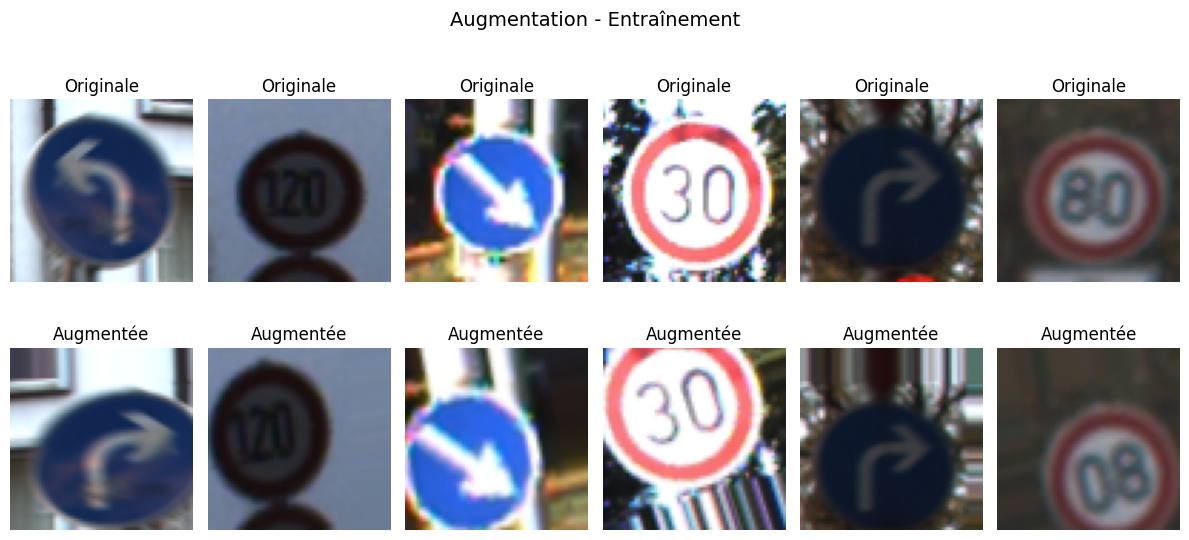

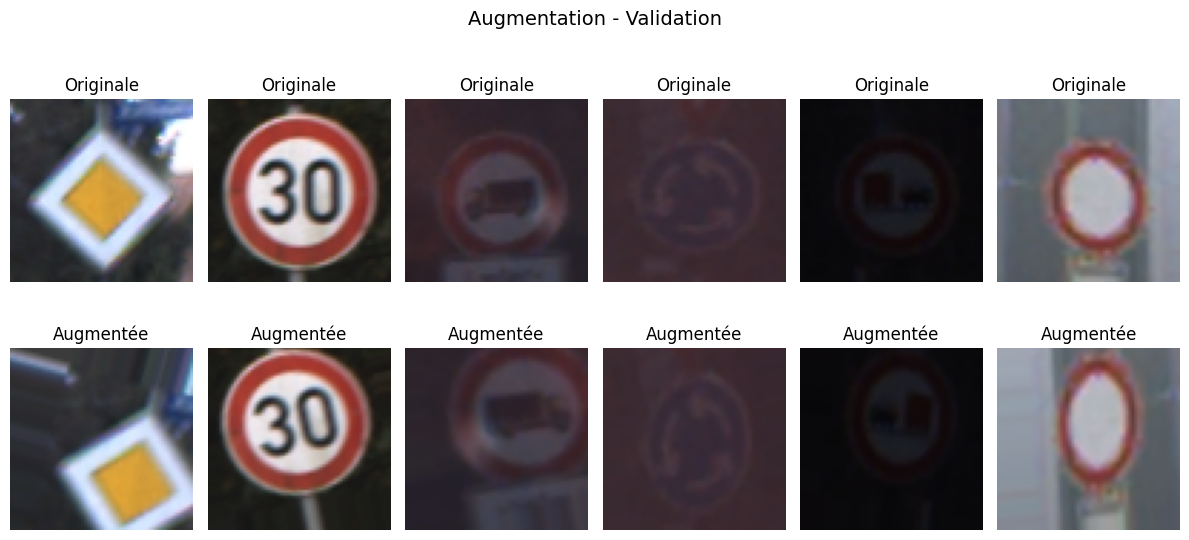

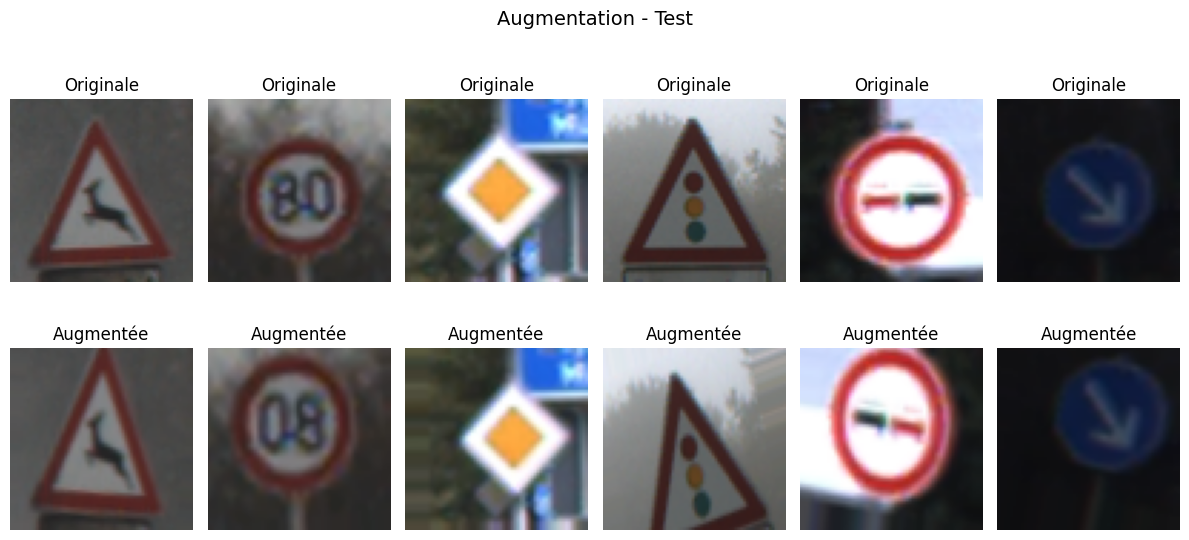

In [27]:
# Affichage des images augmentées
display_augmented_images(X_train, "Augmentation - Entraînement")
display_augmented_images(X_val, "Augmentation - Validation")
display_augmented_images(X_test, "Augmentation - Test")

In [28]:
# Génération des datasets augmentés
X_train_aug, y_train_aug = augment_dataset(X_train, y_train)
X_val_aug, y_val_aug = augment_dataset(X_val, y_val)
X_test_aug, y_test_aug = augment_dataset(X_test, y_test)

# Fusion avec les datasets originaux
X_train_extended = np.concatenate((X_train, X_train_aug), axis=0)
y_train_extended = np.concatenate((y_train, y_train_aug), axis=0)

X_val_extended = np.concatenate((X_val, X_val_aug), axis=0)
y_val_extended = np.concatenate((y_val, y_val_aug), axis=0)

X_test_extended = np.concatenate((X_test, X_test_aug), axis=0)
y_test_extended = np.concatenate((y_test, y_test_aug), axis=0)

# Vérification des nouvelles tailles
print("Nouvelle taille de X_train :", X_train_extended.shape)
print("Nouvelle taille de y_train :", y_train_extended.shape)
print("Nouvelle taille de X_val :", X_val_extended.shape)
print("Nouvelle taille de y_val :", y_val_extended.shape)
print("Nouvelle taille de X_test :", X_test_extended.shape)
print("Nouvelle taille de y_test :", y_test_extended.shape)

Nouvelle taille de X_train : (56654, 64, 64, 3)
Nouvelle taille de y_train : (56654, 43)
Nouvelle taille de X_val : (10000, 64, 64, 3)
Nouvelle taille de y_val : (10000, 43)
Nouvelle taille de X_test : (11764, 64, 64, 3)
Nouvelle taille de y_test : (11764, 43)


In [29]:
print(y_train_extended)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]


## 3. Conception et Implémentation du Modèle CNN

Nous allons créer une classe appelé ImplementModel permettant de définir le nom du modèle, qui sera ensuite compilé avec un optimiseur, entraîné et évalué. Cela facilitera la comparaison entre différents modèles.

In [30]:
class ImplementModel:
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.model = self.build_model()
        self.history = None

    def build_model(self):
        """Méthode à implémenter dans une sous-classe."""
        raise NotImplementedError

    def compile_model(self, optimizer='adam', loss='categorical_crossentropy', metrics=None):
        """Compile le modèle avec un optimiseur et des métriques personnalisées."""
        if metrics is None:
            metrics = ['accuracy']
        self.model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    def fit(self, X_train, y_train, validation_data=None, epochs=10, batch_size=32, callbacks=None):
        """Entraîne le modèle."""
        self.history = self.model.fit(
            X_train, y_train,
            validation_data=validation_data,
            epochs=epochs,
            batch_size=batch_size,
            callbacks=callbacks
        )

    def evaluate_and_plot(self, X_test, y_test):
        """
        Évalue le modèle, affiche la matrice de confusion à gauche et le rapport de classification à droite.
        """
        # Prédictions
        y_pred_prob = self.model.predict(X_test)
        y_pred = np.argmax(y_pred_prob, axis=1)
        y_true = np.argmax(y_test, axis=1)
        
        # Génération du rapport de classification
        target_names = ["Class {}".format(i) for i in range(self.num_classes)]

        # Génération de la matrice de confusion
        cm = confusion_matrix(y_true, y_pred)
        self.plot_confusion_matrix(cm, y_true, y_pred,target_names)

        report = classification_report(y_true, y_pred, output_dict=True)
        metrics = {
        'accuracy': report['accuracy'],
        'macro avg': report['macro avg'],
        'weighted avg': report['weighted avg']
        }
        # Création du DataFrame
        metrics_df = pd.DataFrame(metrics).T
        return metrics_df


    def plot_confusion_matrix(self,cm,y_true,y_pred,target_names):
        fig, axes = plt.subplots(1, 2, figsize=(15, 20))  
        
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, linewidths=1.5, ax=axes[0])
        axes[0].set_xlabel('Predicted')
        axes[0].set_ylabel('True')
        axes[0].set_title('Confusion Matrix')
        
        report_text = classification_report(y_true, y_pred, target_names=target_names)
        axes[1].text(0.1, 0.5, report_text, fontsize=12, va='center', ha='left', family='monospace')
        axes[1].axis('off')  # Désactiver les axes pour le texte
        axes[1].set_title('Classification Report')
        
        plt.tight_layout()
        
        # Affichage de la figure
        plt.show()


### Ce mécanisme TrainingPlot permet de détecter l'overfitting et d'interrompre l'entraînement si nécessaire via l'arrêt précoce (early stopping).

In [31]:
class TrainingPlot(keras.callbacks.Callback):
    # This function is called when the training begins
    def on_train_begin(self, logs={}):
        # Initialize the lists for holding the logs, losses and accuracies
        self.losses = []
        self.acc = []
        self.val_losses = []
        self.val_acc = []
        self.logs = []
        self.max_acc = 0
    
    # This function is called at the end of each epoch
    def on_epoch_end(self, epoch, logs={}):
        
        # Append the logs, losses and accuracies to the lists
        self.logs.append(logs)
        self.losses.append(logs.get('loss'))
        self.acc.append(logs.get('accuracy'))
        self.val_losses.append(logs.get('val_loss'))
        self.val_acc.append(logs.get('val_accuracy'))
        self.max_acc = max(self.max_acc, logs.get('val_accuracy'))
        
        # Before plotting ensure at least 2 epochs have passed
        if len(self.losses) > 1:
            
            # Clear the previous plot
            clear_output(wait=True)
            N = np.arange(0, len(self.losses))
            
            # Plot train loss, train acc, val loss and val acc against epochs passed
            plt.figure(figsize=(8,3))
            plt.plot(N, self.losses, lw=2, c="b", linestyle="-", label = "train_loss")
            plt.plot(N, self.acc, lw=2, c="r", linestyle="-", label = "train_acc")
            plt.plot(N, self.val_losses, lw=2, c="b", linestyle=":", label = "val_loss")
            plt.plot(N, self.val_acc, lw=2, c="r", linestyle=":", label = "val_acc")
            plt.title("Training Loss and Accuracy [Epoch {}, Max Acc {:.4f}]".format(epoch, self.max_acc))
            plt.xlabel("Epoch #")
            plt.ylabel("Loss/Accuracy")
            plt.legend()
            plt.show()

# Version 1: Modèle ModelSimpleCNN

Le modèle **ModelSimpleCNN** est un réseau de neurones convolutif (CNN) conçu pour la classification d'images.

## 1. Entrée

Le modèle prend en entrée des images de dimensions `self.input_shape`.

## 2. Couches Convolutives et Pooling

Le modèle utilise des couches convolutives et de pooling pour extraire des caractéristiques essentielles :

- **Conv2D(16, (3,3)) + ReLU** : La première couche convolutive extrait des motifs simples (comme des bords, des textures ou des formes basiques).Un  nombre réduit de filtres (16) est suffisant pour capturer ces motifs simples.
- **Conv2D(32, (3,3)) + ReLU** : La deuxième couche combine les motifs simples pour en extraire des motifs plus complexes (comme des formes géométriques ou des motifs répétitifs).
- **Conv2D(64, (3,3)) + ReLU** : La troisième couche capture des caractéristiques encore plus abstraites et spécifiques à la tâche (comme des objets ou des parties d'objets).
- **MaxPooling(2,2)** : Réduction de taille.

## 3. Couches Denses

Une fois les caractéristiques extraites :

- **Flatten()** : Transformation en vecteur.
- **Dense(64) + ReLU** : Apprentissage de motifs plus complexes.
- **Dense(self.num_classes) + Softmax** : Prédiction des classes.

In [32]:
class ModelSimpleCNN(ImplementModel):
    def build_model(self):
        model = Sequential()
        model.add(Input(shape=self.input_shape))
        model.add(layers.Conv2D(16, (3, 3), activation='relu'))
        model.add(layers.MaxPooling2D((2, 2)))
        model.add(layers.Conv2D(32, (3, 3), activation='relu'))
        model.add(layers.MaxPooling2D((2, 2)))
        model.add(layers.Conv2D(64, (3, 3), activation='relu'))
        model.add(layers.MaxPooling2D((2, 2)))
        model.add(Flatten())
        model.add(Dense(64, activation='relu'))
        model.add(Dense(self.num_classes, activation='softmax'))
        return model

model_simple_CNN = ModelSimpleCNN(input_shape=(64, 64, 3), num_classes=43)
model_simple_CNN.compile_model(optimizer='adam')
model_simple_CNN.model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 62, 62, 16)          │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 31, 31, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 29, 29, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 12, 12, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2304)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │         147,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 43)                  │           2,795 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 173,899 (679.29 KB)

 Trainable params: 173,899 (679.29 KB)

 Non-trainable params: 0 (0.00 B)

Dernier meilleur score: 98%

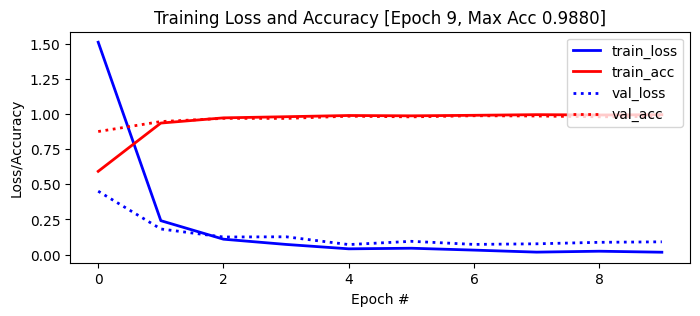

443/443 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9954 - loss: 0.0154 - val_accuracy: 0.9834 - val_loss: 0.0908


In [33]:
earlystop = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=False)
plot_losses = TrainingPlot()  
model_simple_CNN.fit(X_train, y_train, validation_data=(X_val, y_val), 
                     epochs=10, batch_size=64, callbacks=[plot_losses, earlystop])

184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


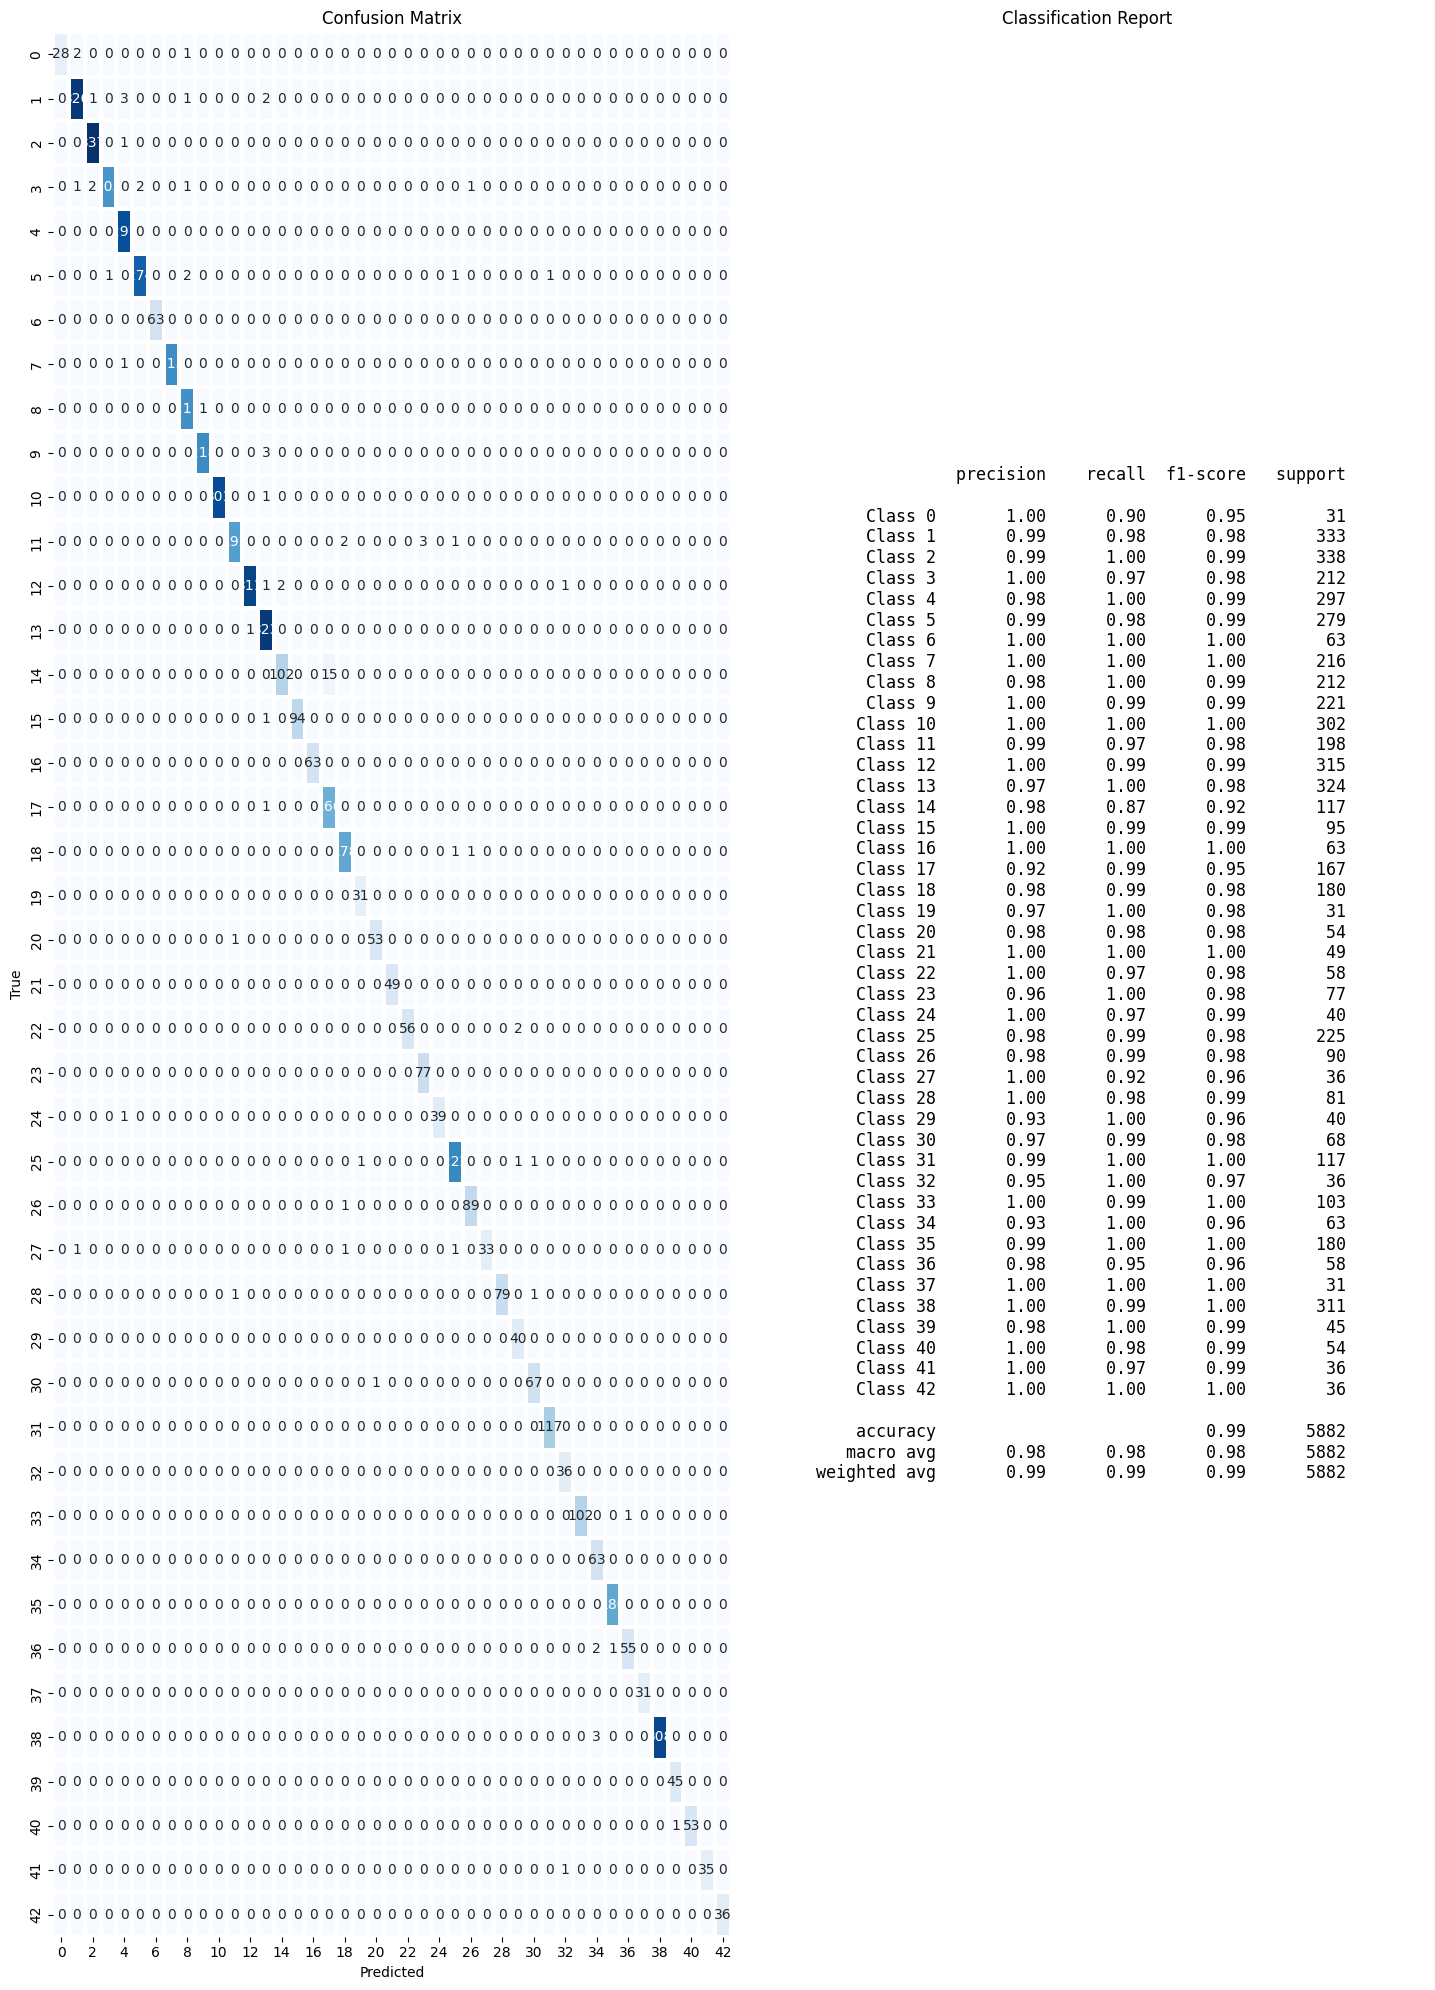

precision    recall  f1-score      support
accuracy       0.986059  0.986059  0.986059     0.986059
macro avg      0.984867  0.982735  0.983446  5882.000000
weighted avg   0.986424  0.986059  0.986027  5882.000000

In [34]:
metrics_simple = model_simple_CNN.evaluate_and_plot(X_test, y_test)
metrics_simple

# Version 2:  Modèle VGG16 pré entrainé ImageNet (Transfer Learning)

Le VGG16 est un modèle de réseau de neurones convolutifs (CNN) très populaire, développé par le Visual Geometry Group (VGG) de l'Université d'Oxford. Il a été l'un des modèles les plus performants lors de sa publication en 2014 et reste largement utilisé aujourd'hui comme architecture de référence pour les tâches de vision par ordinateur.

L'ImageNet est une base de données d’images avec plus de 14 millions d’images classées en 20 000 catégories. Elle sert de référence pour l’entraînement des modèles de vision.

On retire les couches fully connected et on ne conserve que la partie convolutionnelle qui sert d'extracteur de caractéristiques.


L'idée du Transfer Learning est de profiter des connaissances déjà acquises par un modèle pré-entraîné sur un grand dataset (comme ImageNet) et de les transférer à une nouvelle tâche spécifique.
Ici, les couches convolutionnelles de VGG16 servent d'extracteur de caractéristiques, et seules les dernières couches du réseau (celles que vous ajoutez) sont entraînées sur le nouveau dataset.

In [35]:
class ModelpreentrainedVGG16(ImplementModel):
    def build_model(self):
        # Charger le modèle VGG16 pré-entraîné sur imagenet sans les couches fully connected (include_top=False)
        base_model = VGG16(weights='imagenet',include_top=False, input_shape=self.input_shape)
        
        # Geler toutes les couches du modèle de base pour ne pas les entraîner  
        base_model.trainable = False
        
        # Créer un nouveau modèle
        model = Sequential()
        
        # Ajouter le modèle VGG16
        model.add(base_model)
        
        # Ajouter les couches fully connected
        model.add(Flatten())
        model.add(Dense(256, activation='relu'))
        model.add(Dense(self.num_classes, activation='softmax'))
        
        return model

model_VGG16 = ModelpreentrainedVGG16(input_shape=(64, 64, 3), num_classes=43)
model_VGG16.compile_model(optimizer='adam')
model_VGG16.model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 2, 2, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         524,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 43)                  │          11,051 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,250,283 (58.18 MB)

 Trainable params: 535,595 (2.04 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

Derniers résultats trouvés :

**Temps exécution plus court moins de 2 minutes**  <br>
- 128 neurones = 91.4% pour 10 epochs / batch size= 64  <br>
- 256 neurones = 92.2% pour 10 epochs / batch size= 64 <br>

**Temps exécution plus long environ 2-5 min** <br>
- **128 neurones = 94% pour 20 epochs / batch size=128** <br>
- 256 neurones = 93.3% pour 20 epochs / batch size=128 <br>

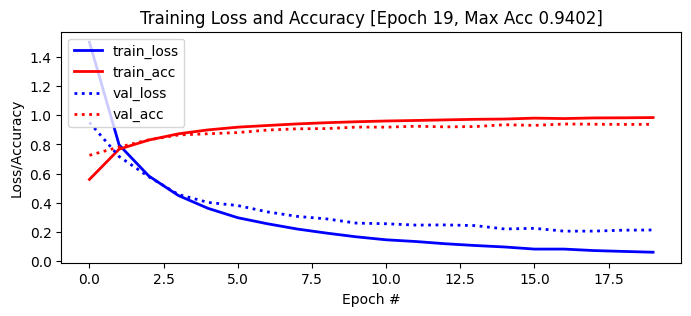

222/222 ━━━━━━━━━━━━━━━━━━━━ 12s 54ms/step - accuracy: 0.9859 - loss: 0.0599 - val_accuracy: 0.9380 - val_loss: 0.2148


In [36]:
earlystop = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=False)
plot_losses = TrainingPlot()  
model_VGG16.fit(X_train, y_train, validation_data=(X_val, y_val), 
                     epochs=20, batch_size=128, callbacks=[plot_losses, earlystop])

184/184 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step


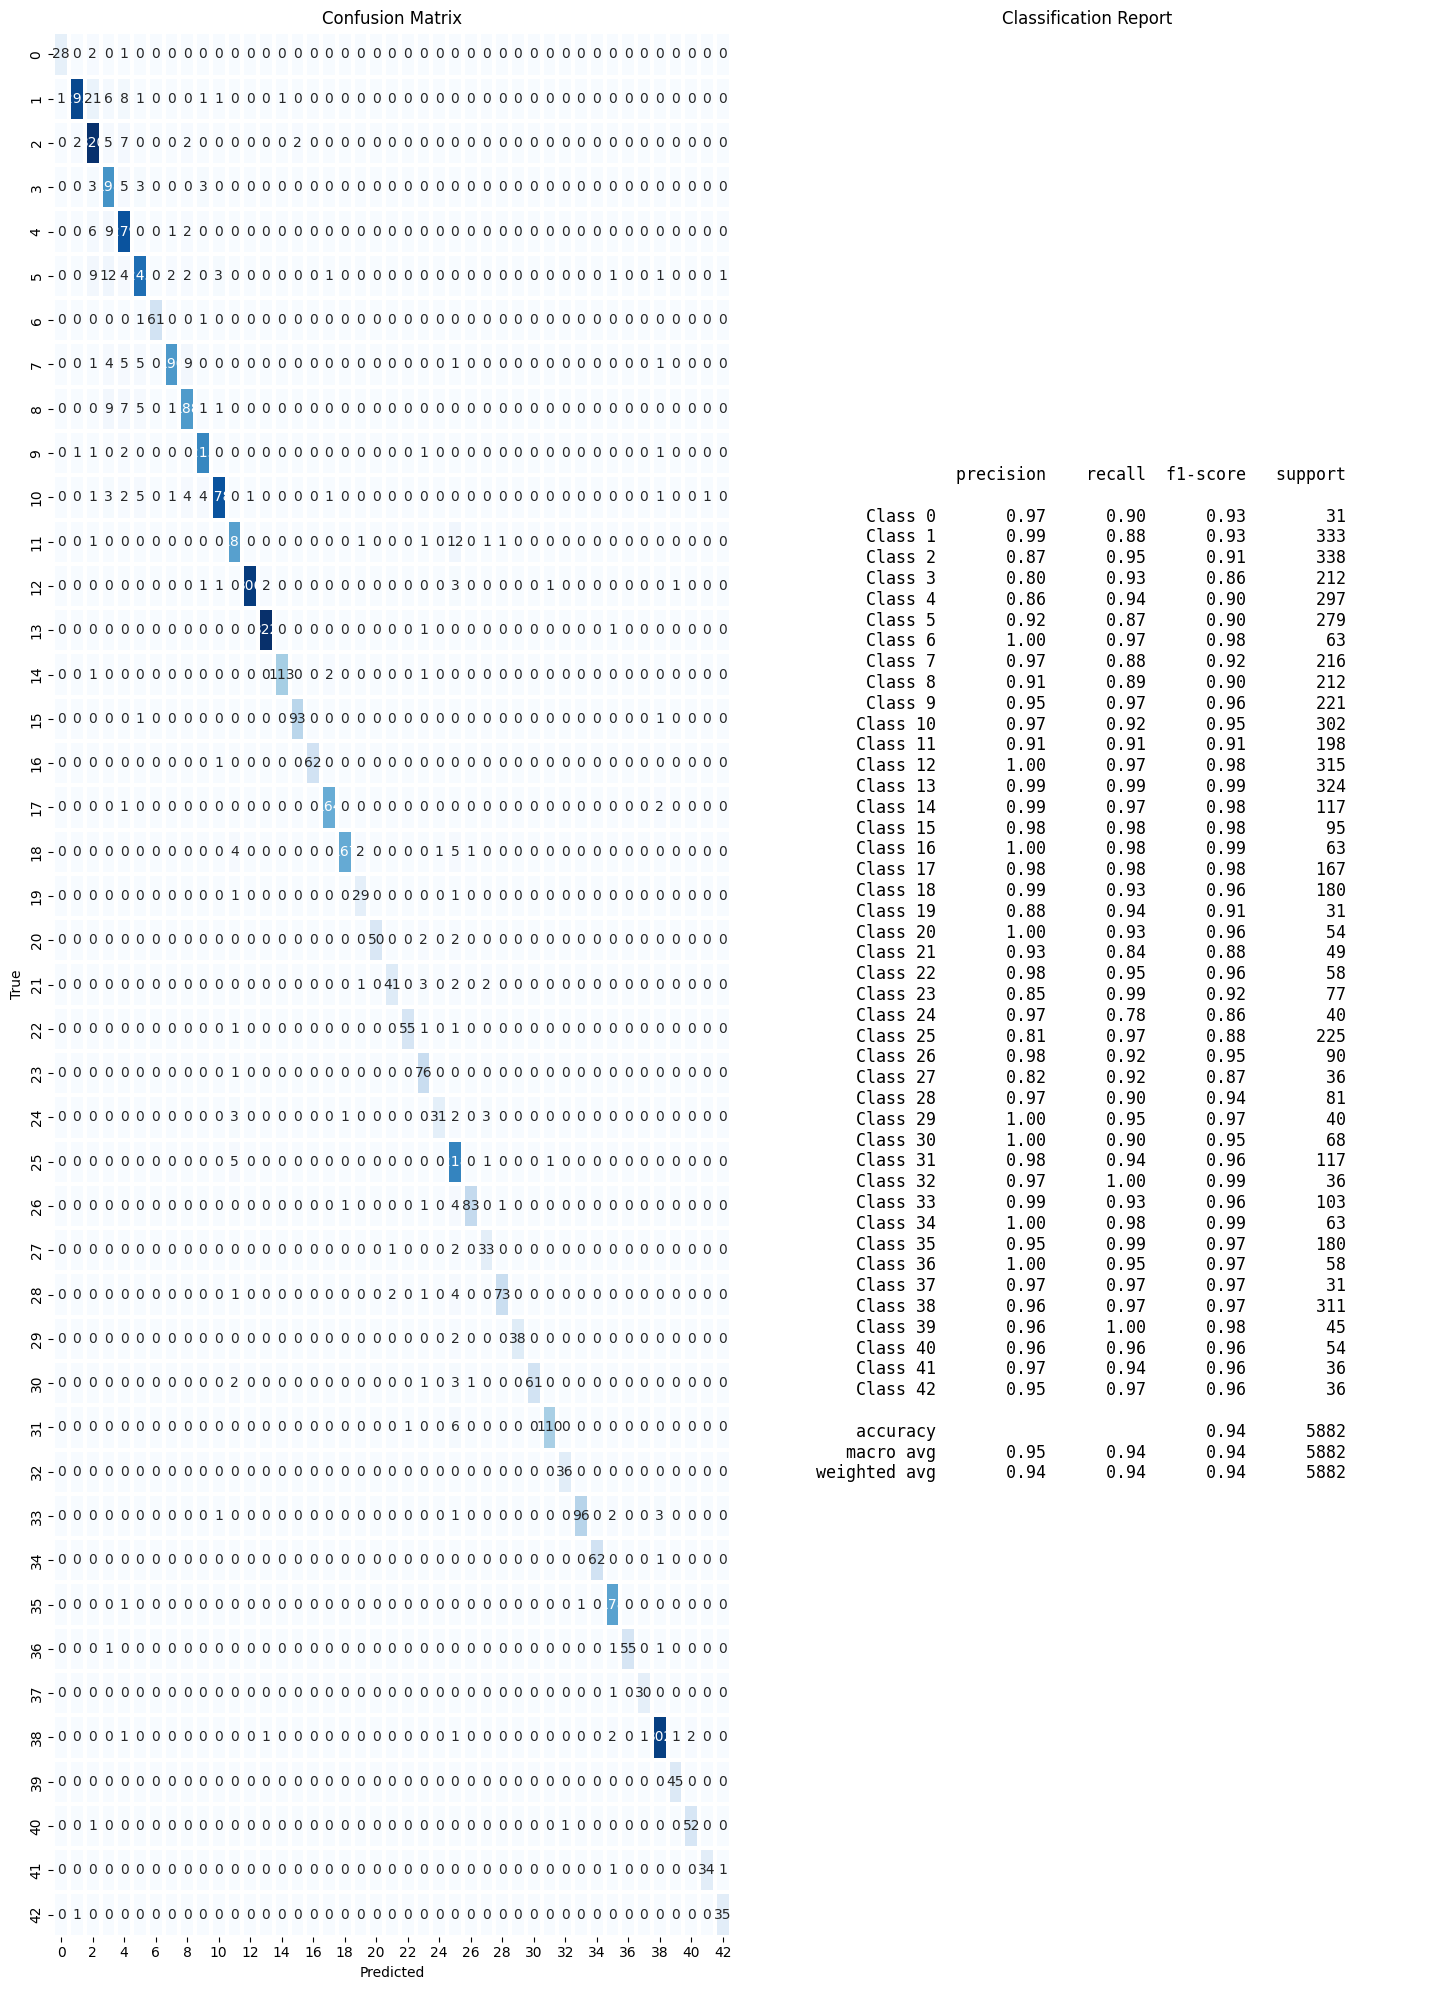

precision    recall  f1-score      support
accuracy       0.939136  0.939136  0.939136     0.939136
macro avg      0.951372  0.939460  0.944079  5882.000000
weighted avg   0.942891  0.939136  0.939682  5882.000000

In [37]:
metrics_VGG16 = model_VGG16.evaluate_and_plot(X_test, y_test)
metrics_VGG16

# Version 3: Model Regularization

Ce modèle est optimisé pour la classification avec des techniques de régularisation qui améliorent sa capacité à bien généraliser sur des données non vues. 

- **BatchNormalization:**

Stabilise l'entraînement en réduisant le décalage covariant (changement de la distribution des entrées à chaque couche).
Accélère la convergence en permettant un taux d’apprentissage plus élevé.

- **Dropout:**

Réduit le surapprentissage en forçant le réseau à ne pas dépendre trop fortement de certains neurones.
Améliore la robustesse du modèle en introduisant du bruit aléatoire pendant l’entraînement.

In [38]:
class RegularizedCNN(ImplementModel):
    def build_model(self):
        model = Sequential()
        model.add(Input(shape=self.input_shape))
        
        # Première couche convolutive
        model.add(layers.Conv2D(16, (3, 3), activation='relu'))
        model.add(BatchNormalization()) 
        model.add(layers.MaxPooling2D((2, 2)))
        model.add(Dropout(0.25))  
        
        # Deuxième couche convolutive
        model.add(layers.Conv2D(32, (3, 3), activation='relu'))
        model.add(BatchNormalization()) 
        model.add(layers.MaxPooling2D((2, 2)))
        model.add(Dropout(0.25))  
        
        # Troisième couche convolutive
        model.add(layers.Conv2D(64, (3, 3), activation='relu'))
        model.add(BatchNormalization()) 
        model.add(layers.MaxPooling2D((2, 2)))
        model.add(Dropout(0.25))  # Dropout après le pooling
        
        # Couche fully connected
        model.add(Flatten())
        model.add(Dense(64, activation='relu'))
        model.add(Dropout(0.5)) 

        # Couche de sortie
        model.add(Dense(self.num_classes, activation='softmax'))
        
        return model

model_RegularizedCNN = RegularizedCNN(input_shape=(64, 64, 3), num_classes=43)
model_RegularizedCNN.compile_model(optimizer='adam')
model_RegularizedCNN.model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 62, 62, 16)          │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 62, 62, 16)          │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 31, 31, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 31, 31, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 29, 29, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 29, 29, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 12, 12, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 12, 12, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 2304)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │         147,520 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 43)                  │           2,795 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 174,347 (681.04 KB)

 Trainable params: 174,123 (680.17 KB)

 Non-trainable params: 224 (896.00 B)

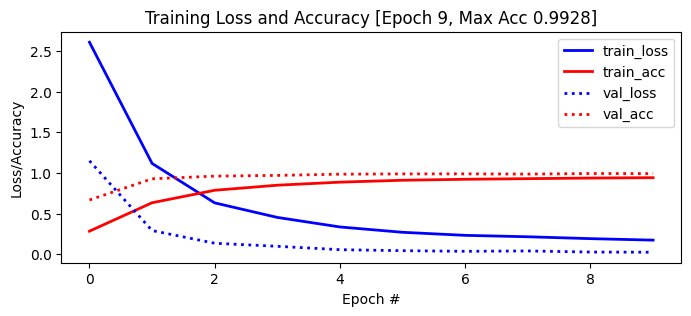

443/443 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9410 - loss: 0.1753 - val_accuracy: 0.9916 - val_loss: 0.0259


In [39]:
earlystop = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=False)
plot_losses = TrainingPlot()  
model_RegularizedCNN.fit(X_train, y_train, validation_data=(X_val, y_val), 
                     epochs=10, batch_size=64, callbacks=[plot_losses, earlystop])

184/184 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


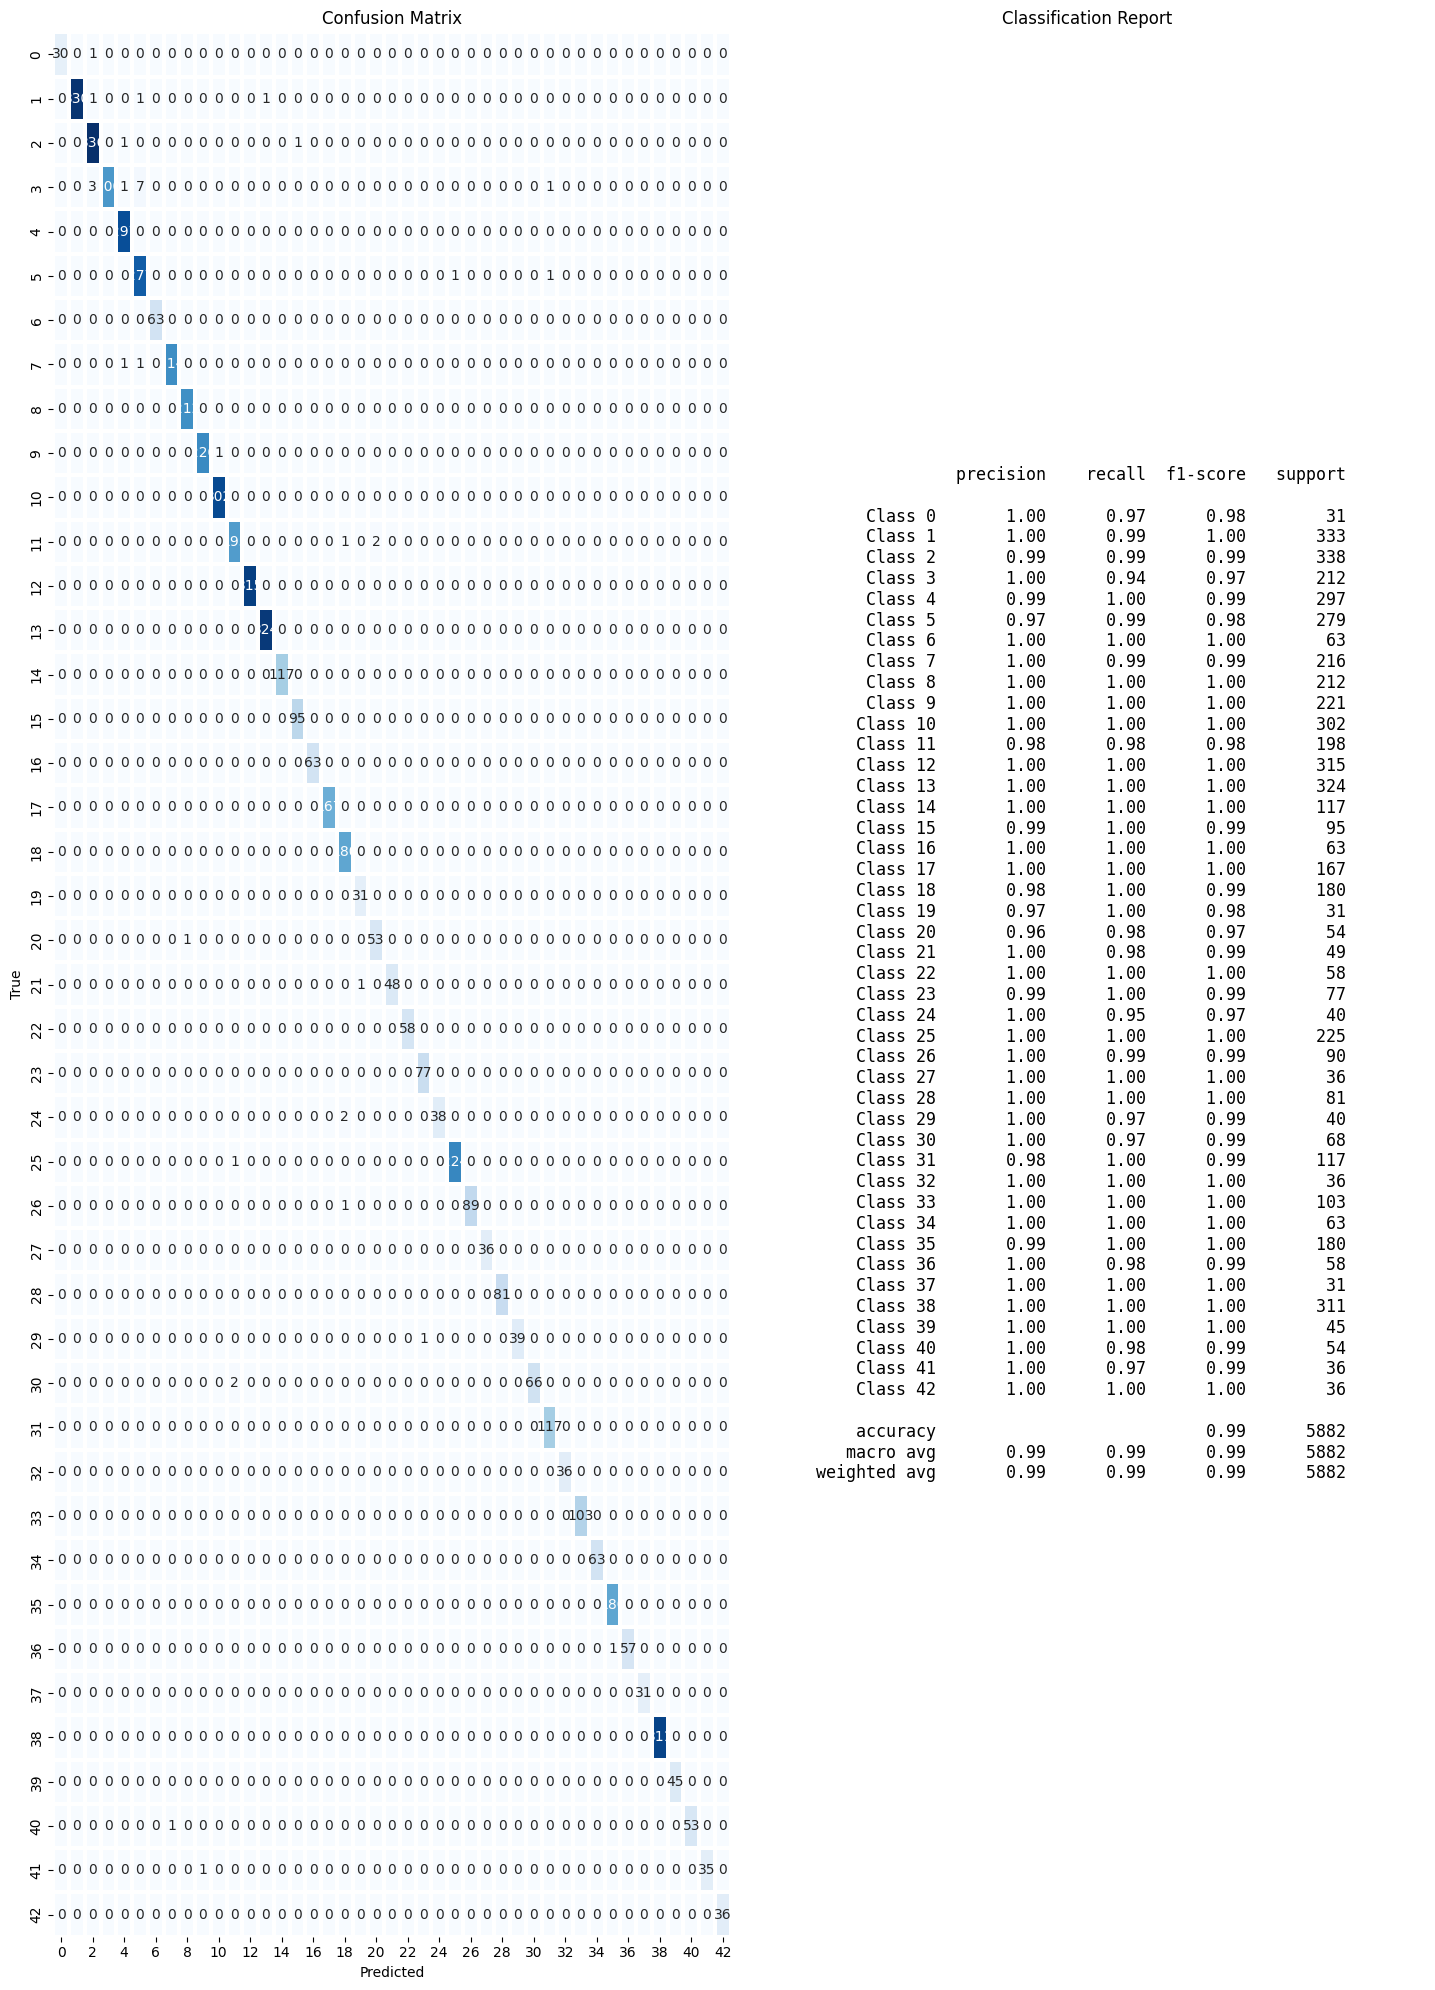

precision    recall  f1-score     support
accuracy       0.993540  0.993540  0.993540     0.99354
macro avg      0.994630  0.991574  0.993022  5882.00000
weighted avg   0.993628  0.993540  0.993521  5882.00000

In [40]:
metrics_regularizedCNN = model_RegularizedCNN.evaluate_and_plot(X_test, y_test)
metrics_regularizedCNN

# Comparaison des performances des modèles

| **Métrique**         | **Quand l'utiliser ?**                           | **Avantage**                         | **Inconvénient**                      |
|----------------------|-------------------------------------------------|--------------------------------------|---------------------------------------|
| **Accuracy**         | Classes équilibrées                              | Facile à comprendre                  | Trompeur si classes déséquilibrées    |
| **Macro Average**    | Prendre en compte **toutes** les classes également | Évalue bien les petites classes      | Ne considère pas la taille des classes |
| **Weighted Average** | Prendre en compte la **taille** des classes       | Reflète mieux les classes majoritaires | Sous-estime les erreurs sur les petites classes |

### **Comparaison globale**

#### **RegularizedCNN**
- C'est le meilleur modèle sur tous les plans : **accuracy**, **macro avg** et **weighted avg**.
- Il est probablement bien régularisé, ce qui lui permet de généraliser efficacement sans surapprentissage.

#### **SimpleCNN**
- Performances très bonnes, mais légèrement inférieures à celles du **RegularizedCNN**.
- Il est plus simple que le **VGG16**, mais semble mieux adapté à ce jeu de données.

#### **VGG16**
- Le moins performant des trois modèles.
- Cela peut être dû à une complexité excessive (surapprentissage) ou à un déséquilibre des classes qui affecte davantage ce modèle.

In [41]:
metrics = {}

metrics["SimpleCNN"] = metrics_simple
metrics["VGG16"] = metrics_VGG16
metrics["RegularizedCNN"] = metrics_regularizedCNN

for name_model, report in metrics.items():
    print(f"--- Performance du modèle {name_model} ---")
    print(report)

--- Performance du modèle SimpleCNN ---
              precision    recall  f1-score      support
accuracy       0.986059  0.986059  0.986059     0.986059
macro avg      0.984867  0.982735  0.983446  5882.000000
weighted avg   0.986424  0.986059  0.986027  5882.000000
--- Performance du modèle VGG16 ---
              precision    recall  f1-score      support
accuracy       0.939136  0.939136  0.939136     0.939136
macro avg      0.951372  0.939460  0.944079  5882.000000
weighted avg   0.942891  0.939136  0.939682  5882.000000
--- Performance du modèle RegularizedCNN ---
              precision    recall  f1-score     support
accuracy       0.993540  0.993540  0.993540     0.99354
macro avg      0.994630  0.991574  0.993022  5882.00000
weighted avg   0.993628  0.993540  0.993521  5882.00000


### ** Bilan de performance**
- **RegularizedCNN** est clairement le meilleur choix pour ce jeu de données, avec des performances supérieures en termes de précision, rappel et F1-score.
- **SimpleCNN** est une bonne alternative si l'on recherche un modèle plus simple mais performant.
- **VGG16** semble moins adapté à ce problème spécifique en raison de sa complexité.

# Visualisation des activations de couches

Les activations des couches convolutives d’un réseau de neurones convolutif (CNN) mettent en évidence les caractéristiques spécifiques apprises à chaque étape de l’entraînement. Les visualiser permet de comprendre quelles zones de l’image provoquent des réactions dans les différentes couches et d’analyser la manière dont le réseau interprète les motifs visuels.

Cette exploration peut également aider à identifier des dysfonctionnements dans le modèle, tels que des filtres peu informatifs ou un surapprentissage (overfitting) sur certaines parties du jeu de données

In [42]:
img_tensor = X_val[1]  ##Changement d'image
img_tensor = np.expand_dims(img_tensor, axis=0) 

# Extracts the outputs of the top 6 layers:
layer_outputs = [layer.output for layer in model_simple_CNN.model.layers[:6]]

In [43]:
# Creates a model that will return these outputs, given the model input:
activation_model_regulazation = models.Model(inputs=model_simple_CNN.model.inputs, outputs=layer_outputs)

# This will return a list of 5 Numpy arrays:
# one array per layer activation
activations = activation_model_regulazation.predict(img_tensor)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 605ms/step


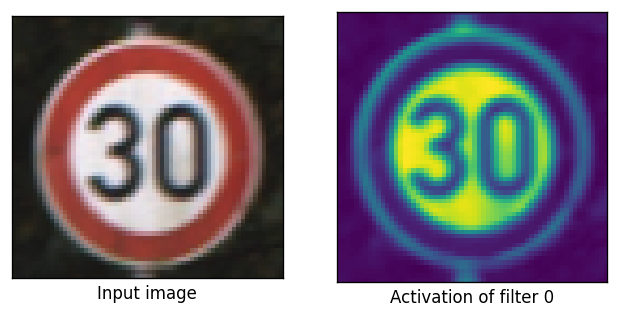

In [44]:
plt.rcParams['figure.dpi'] = 120
first_layer_activation = activations[0]

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.imshow(img_tensor[0])
ax2.matshow(first_layer_activation[0, :, :, 2], cmap='viridis')
ax1.set_xticks([])
ax1.set_yticks([])
ax2.set_xticks([])
ax2.set_yticks([])
ax1.set_xlabel('Input image')
ax2.set_xlabel('Activation of filter 0');

In [45]:
images_per_row = 16

layer_names = []
for layer in model_RegularizedCNN.model.layers[:6]:
    layer_names.append(layer.name)

def plot_activations(layer_index, activations):
    start = layer_index
    end = layer_index+1
    # Now let's display our feature maps
    for layer_name, layer_activation in zip(layer_names[start:end], activations[start:end]):
        # This is the number of features in the feature map
        n_features = layer_activation.shape[-1]

        # The feature map has shape (1, size, size, n_features)
        size = layer_activation.shape[1]

        # We will tile the activation channels in this matrix
        n_cols = n_features // images_per_row
        display_grid = np.zeros((size * n_cols, images_per_row * size))

        # We'll tile each filter into this big horizontal grid
        for col in range(n_cols):
            for row in range(images_per_row):
                channel_image = layer_activation[0,
                                                 :, :,
                                                 col * images_per_row + row]
                # Post-process the feature to make it visually palatable
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[col * size : (col + 1) * size,
                             row * size : (row + 1) * size] = channel_image

        # Display the grid
        scale = 1. / size
        plt.figure(figsize=(scale * display_grid.shape[1],
                            scale * display_grid.shape[0]))
        plt.title("Activation of layer {} ({})".format(layer_index+1,layer_name))
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')

    plt.show()

<ipython-input-45-1f2712b18862>:30: RuntimeWarning: invalid value encountered in divide
  channel_image /= channel_image.std()
<ipython-input-45-1f2712b18862>:33: RuntimeWarning: invalid value encountered in cast
  channel_image = np.clip(channel_image, 0, 255).astype('uint8')


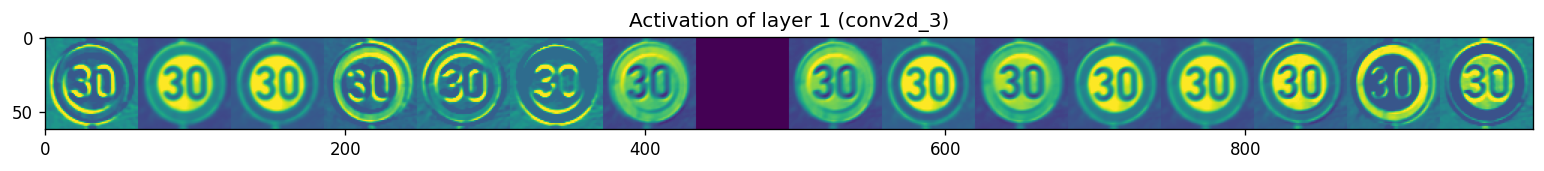

In [46]:
plot_activations(0, activations);

<ipython-input-45-1f2712b18862>:30: RuntimeWarning: invalid value encountered in divide
  channel_image /= channel_image.std()
<ipython-input-45-1f2712b18862>:33: RuntimeWarning: invalid value encountered in cast
  channel_image = np.clip(channel_image, 0, 255).astype('uint8')


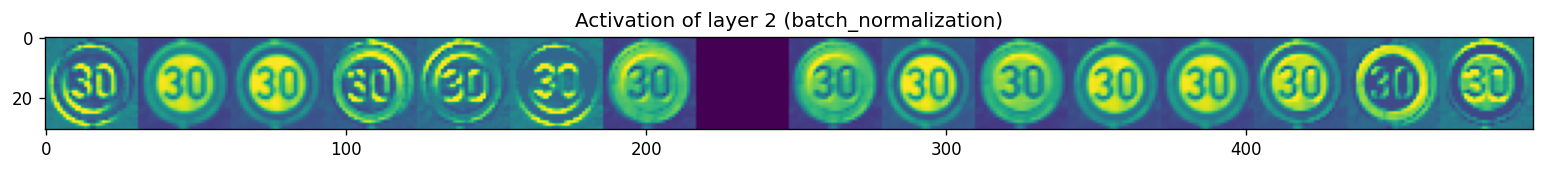

In [47]:
plot_activations(1, activations);

<ipython-input-45-1f2712b18862>:30: RuntimeWarning: invalid value encountered in divide
  channel_image /= channel_image.std()
<ipython-input-45-1f2712b18862>:33: RuntimeWarning: invalid value encountered in cast
  channel_image = np.clip(channel_image, 0, 255).astype('uint8')


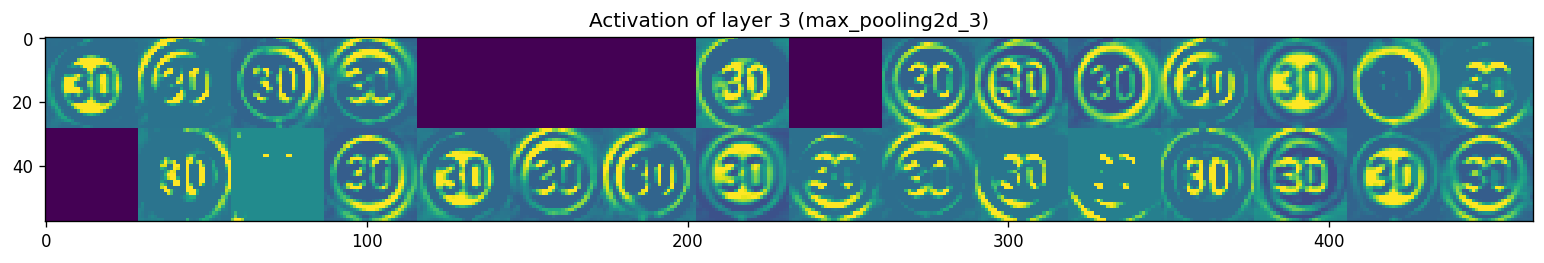

In [48]:
plot_activations(2, activations);

<ipython-input-45-1f2712b18862>:30: RuntimeWarning: invalid value encountered in divide
  channel_image /= channel_image.std()
<ipython-input-45-1f2712b18862>:33: RuntimeWarning: invalid value encountered in cast
  channel_image = np.clip(channel_image, 0, 255).astype('uint8')


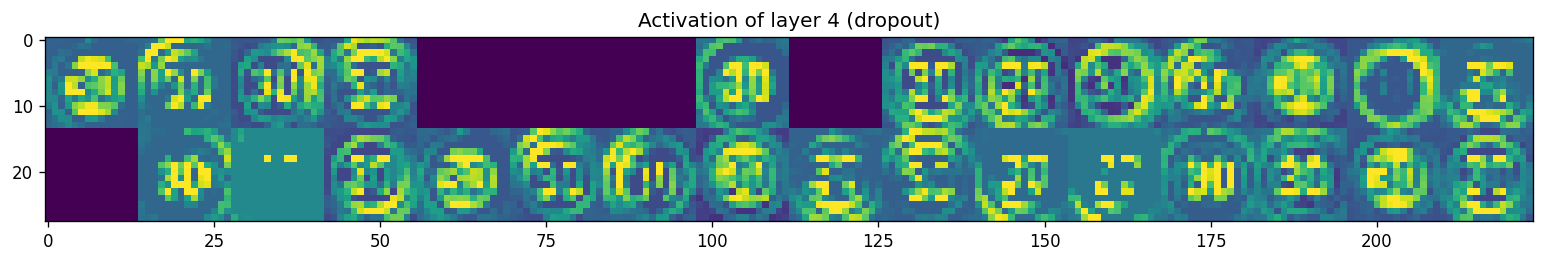

In [49]:
plot_activations(3, activations);

<ipython-input-45-1f2712b18862>:30: RuntimeWarning: invalid value encountered in divide
  channel_image /= channel_image.std()
<ipython-input-45-1f2712b18862>:33: RuntimeWarning: invalid value encountered in cast
  channel_image = np.clip(channel_image, 0, 255).astype('uint8')


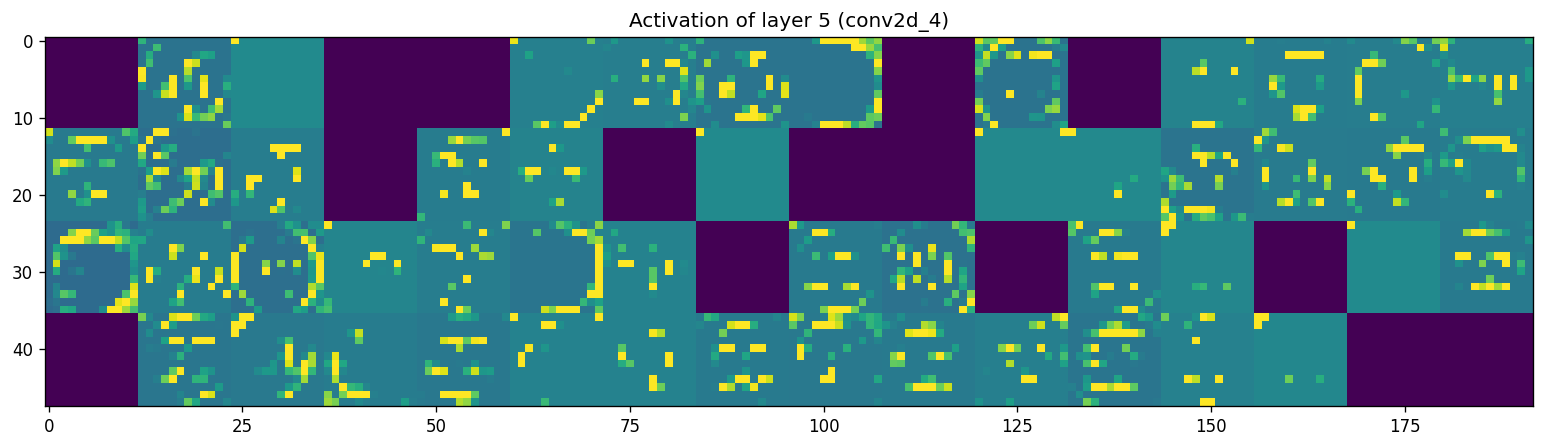

In [50]:
plot_activations(4, activations);

<ipython-input-45-1f2712b18862>:30: RuntimeWarning: invalid value encountered in divide
  channel_image /= channel_image.std()
<ipython-input-45-1f2712b18862>:33: RuntimeWarning: invalid value encountered in cast
  channel_image = np.clip(channel_image, 0, 255).astype('uint8')


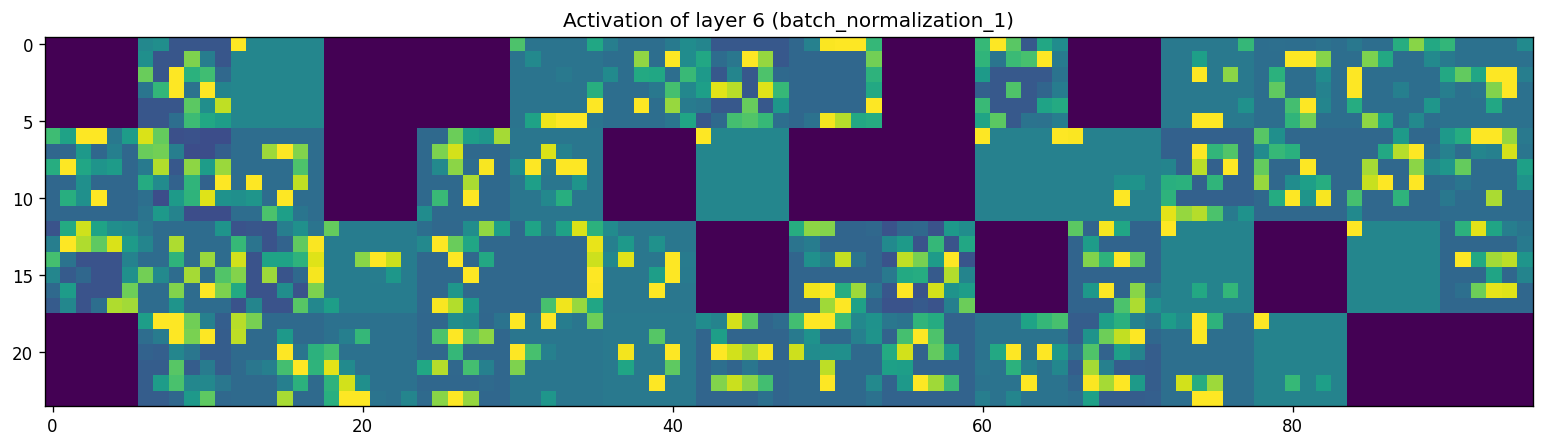

In [51]:
plot_activations(5, activations);

# Interpretation via Grad-CAM

Le Grad-CAM est un outil d'interprétabilité qui permet de repérer visuellement les zones de l'image ayant le plus contribué à la prédiction du modèle. Cela aide à déterminer si le modèle prend des décisions cohérentes ou s'il est influencé par des caractéristiques non pertinentes.

In [52]:
load_simple_cnn_model.summary()

NameError: name 'load_simple_cnn_model' is not defined

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import models
from IPython.display import clear_output

# Charger une image
img_tensor = X_val[1]  # Changer l'image si nécessaire
img_tensor = np.expand_dims(img_tensor, axis=0)

# Sélectionner la dernière couche convolutionnelle
last_conv_layer = model_simple_CNN.model.get_layer("conv2d_8")

grad_model = Model(
    inputs=model_simple_CNN.model.input, 
    outputs=[load_simple_cnn_model.output, last_conv_layer.output]
)

def compute_gradcam(img_tensor, grad_model, last_conv_layer):
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_tensor)
        class_idx = tf.argmax(predictions[0])  # Classe prédite
        loss = predictions[:, class_idx]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0] * pooled_grads
    heatmap = tf.reduce_mean(conv_outputs, axis=-1)
    heatmap = np.maximum(heatmap, 0)  # ReLU
    heatmap /= np.max(heatmap)  # Normalisation
    return heatmap

heatmap = compute_gradcam(img_tensor, grad_model, last_conv_layer)

# Affichage du résultat
plt.matshow(heatmap)
plt.show()
